# **Road Field Classifier - Merlin Rousseau**

The aim of this project is to perform classification on roads and fields images. To do so, I have trained a Convolutionnal Neural Network with an architecture inspired from AlexNet one with few addings.

In [1]:
# The following package needs to be installed
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Usefull imports
import os
import shutil

import torch
import torchvision

In [3]:
# Change working directory to project directory 
os.chdir('/content/drive/MyDrive/Road_Field_Classification') # PUT YOUR PATH HERE

WORK_DIR = os.getcwd()
DATA_PATH = os.path.join(WORK_DIR, 'dataset')

# **Data discussions** 



## Review of data and preparation

The provided dataset contains 153 train images (45 fields and 108 roads) and 10 unlabeled test images.

By quickly looking at images, I noticed that two field images ('3.jpg' and '5.jpg') are misclassified so I moved them into the road folder (using a different names because they are already taken).

<br/>
<
In order to correctly evaluate my model performances, I need to create training and validation datasets. 

I chose to create a balanced validation set (i.e. same number road and field images) to check if the network is able to generalize well over both classes.

The validation set will contain 10 road images and 10 field images, it corresponds to around 13% of the provided dataset which is lower than the common value (20%) but I did not want to amputate the training set with too many field images.

The resulting sets have the following class distributions :
- Train set : 33 field and 100 road images
- Validation set : 10 field and 10 road images
- Test set : 10 unlabeled images 

<br/> 

The following function performs all described transformations made to the dataset files.

In [4]:
from utils import extract_dataset_prepare_folders_split

# If 'WORK_DIR/dataset' does not exists, it means data extraction and directories preparation have not been done
# Run homemade script to extract and modify folders architecture, it will also split the data into training and validation
if not os.path.exists(DATA_PATH):
    extract_dataset_prepare_folders_split(WORK_DIR)

As the training dataset is imbalanced and low in size, I will focus on avoiding overfitting.

<br/>

To prevent the model from always seeing the same images at each epoch, I used data augmentation on training images which is the composition of the following image transformations :
- Random rotation between -10 and 10 degrees (This should help to generalize over images that are not centered on horizon, I don't want to tilt images too much as this may affect road's and field's perspective)
- Random horizontal flip with a 0.5 probability (Flip images from left to right, I did not apply vertical flip because it would change perspective too)
- Random cropping with scale of 1 to 0.5 (Increase the variety of images while avoiding to loose too much of their global information) followed by resizing to (64, 64) which is my model input size

I did not use any color transformation because it most likely contains a lot of useful information for classification and I'm not confident about changing those parameters.

Validation and test images are only resized to (64, 64).

Resizing an image to a smaller size will induce information loss but it will reduce the neural network complexity and thus the epoch time.

<br/>

In order to avoid overfitting on the majority class (road in our dataset), I used a weighted random sampler so that on average the batches are class balanced. In the dataset, since there are 3 times more road images, the probability of selecting a field image for a batch will be three times higher than that of a road.

In [5]:
from utils import get_device, get_data_loader, get_transform, show_images_from_data_loader, show_transformation_examples

In [6]:
# I do not want a too small batch size because of batch normalization layers
# 10 is convenient considering my datasets sizes
BATCH_SIZE = 10

# Prepare data loaders with training and validation images
data_loader_train = get_data_loader(os.path.join(DATA_PATH, 'train'), 'train', BATCH_SIZE, shuffle=True)
data_loader_val = get_data_loader(os.path.join(DATA_PATH, 'val'), "val", BATCH_SIZE, shuffle=True)

Examples of transformations applied to training images

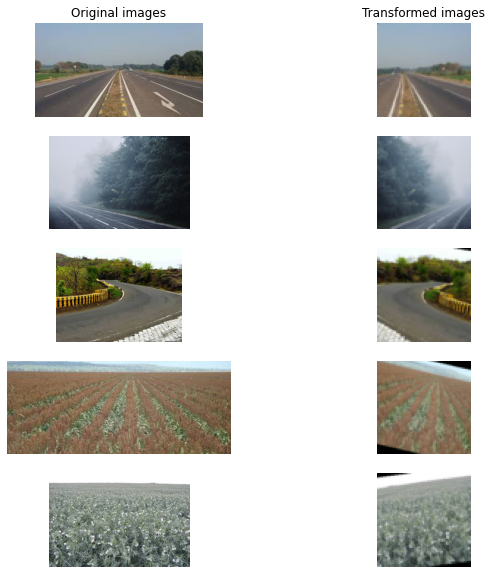

In [7]:
show_transformation_examples(data_loader_train)

Below are the resized images that will be used for validation, they seem quite varied.

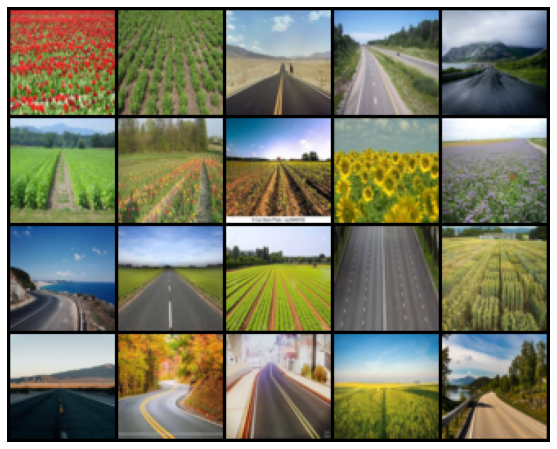

In [ ]:
show_images_from_data_loader(data_loader_val)

# **Network architecture**

The proposed CNN architecture is inspired of AlexNet and can be divided into two parts : features extraction and classification.

<br/>

The feature extractor is composed of 3 convolutional blocks. Each block is composed of a 2D convolutional layer with kernel size (3, 3) and padding 1, a 2D batch normalization layer, a ReLU activation function and a 2D max pooling layer with kernel size (2, 2).

Convolutionnal layers extract high-level information from the input by computing K feature maps. In my architecture, the feature maps have the same size as the input ones due to kernel size and padding.

Batch normalization layers helps to mitigate the internal covariate shift which is the change of the convolution layer output distribution due to the modification of layer parameters during training. Those layers are widely used to speed up the learning process of a model as well as producing more reliable results.

ReLU activation is used because it is significantly faster than softmax or sigmoid due to its computational simplicity and that of its gradient. \
Max pooling layers reduce input dimensionnality by summarizing the feature maps. Thus, this makes the convolutional network less computationally expensive and less sensitive to variations in the position of the features in the input image.

Therefore, each convolutional block of my network returns feature maps half the size of the input.
As we move forward in the convolutional layers, the patterns to learn get more complex. Hence, successive convolutional layers need an increasing number of kernels to extract more high-level information. The first convolutional layer of my model uses 8 kernels, the second employs 16 kernels and the last one utilizes 32 kernels.

The feature extractor takes as input an image of size (3, 64, 64). The first convolutional block produces a (8, 32, 32) output corresponding to the 8 normalized and pooled feature maps. This is then forwarded into the second convolutional block which returns a (16, 16, 16) output. The last convolutional block takes this as input to produce a (32, 8, 8) output.

The resulting 32 feature maps of size (8, 8) are then flattened to be forwarded into the classification module.

<br/>

The classification module is composed of two fully connected layers.

The first layer takes the flattened input of length 2048 to process an output of size 256. ReLU activation is then performed on the layer output and half of the features are set to 0 using a dropout layer to prevent overfitting.

Finally, the last fully connected layer produces an output of size 2 to which a softmax activation is applied. The result is an output of length 2 which corresponds to the probability predictions for each of the classes.

<br/>

Below, you will find a model summary.

In [8]:
from model import CustomBinaryClassifier
from torchsummary import summary

field_road_classifier = CustomBinaryClassifier()
summary(field_road_classifier.to(get_device()), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 64, 64]             224
       BatchNorm2d-2            [-1, 8, 64, 64]              16
              ReLU-3            [-1, 8, 64, 64]               0
         MaxPool2d-4            [-1, 8, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           1,168
       BatchNorm2d-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
         MaxPool2d-8           [-1, 16, 16, 16]               0
            Conv2d-9           [-1, 32, 16, 16]           4,640
      BatchNorm2d-10           [-1, 32, 16, 16]              64
             ReLU-11           [-1, 32, 16, 16]               0
        MaxPool2d-12             [-1, 32, 8, 8]               0
           Linear-13                  [-1, 256]         524,544
          Dropout-14                  [

# **Model training and evaluation**

My network architecture is trained by repeating for a given number of epochs the following steps : for each batch in the data loader, forward images through the network to output predictions, compute the loss by comparing these predictions to the true labels, update model network weights with the given optimizer according to the gradient of the loss function (aim to minimize the loss for each batch).

<br/>

The criterion used is called cross entropy loss. It is a commonly used criterion in classification problems as it can be interpreted as the distance between true labels and their corresponding predicted probabilities.

I chose ADAM as the optimizer to update models weights and minimize the loss because of its popularity and ability to adapt the learning rate during the training process.

<br/>

At the end of each epoch, the model is evaluated using the validation images. Two metrics are used to estimate model performances : accuracy and AUC ROC.

Accuracy is the most common metric as it measures the proportion of correct predictions.

The Area Under the Receiver Operating Characteristic Curve (AUC ROC) allows the performance of the binary classification model to be assessed more accurately. The ROC is a curve that plots the true positive rate (ability to predict roads as roads) versus the false positive rate (ability to predict fields as fields) using different thresholds on the probability predictions. Higher the area under this curve, the better the model is at classifying roads and fields. AUC ROC does not perform well on imbalanced datasets that's why I previously created a balanced validation dataset.

At each evaluation, if the model performs equally or better in both accuracy and ROC AUC, network weights are saved. As the validation set is small, evaluate the model ability to generalize well on new images is a difficult task because I might reach correct predictions on all 20 validation images at many different epochs. Also, the validation images and future test images might have completely different distributions. K-fold cross validation might be a solution to mitigate this issue.

Let's train our first network

In [9]:
from train import train_model

The first training run is performed with the default learning rate of ADAM and 100 epochs

Training in process
End of training
Best model selected at epoch 99


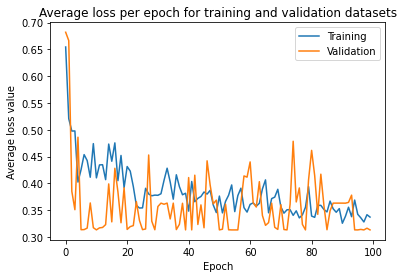

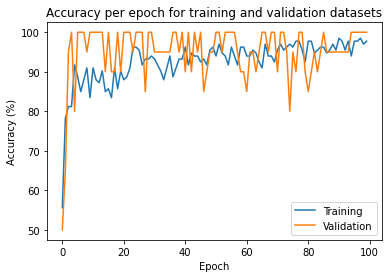

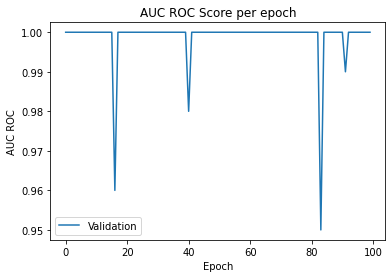

In [13]:
epochs = 100
learning_rate = 0.001 # Default value of ADAM
field_road_classifier = CustomBinaryClassifier('_e100_lr1e-3') # saving_suffix : 100 epochs + lr 1e-3
optimizer = torch.optim.Adam(params=field_road_classifier.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
train_model(data_loader_train, data_loader_val, field_road_classifier, criterion, optimizer, epochs, verbose=False)

The model is not learning well as there are huge drops on accuracy and loss curves of the validation set unlike training set, i.e. curves does not converge well.

Because the training set is not very large, I want to prevent the model from learning too last from the first batches and thus learn from more transformed images. So, I lowered the learning rate by a factor of 10.

Training in process
End of training
Best model selected at epoch 6


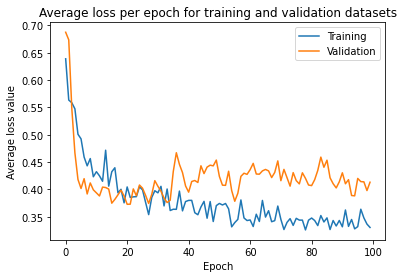

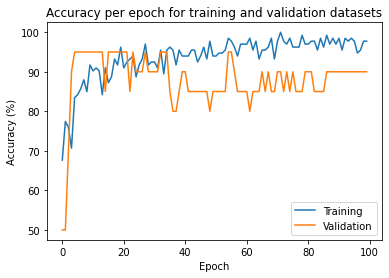

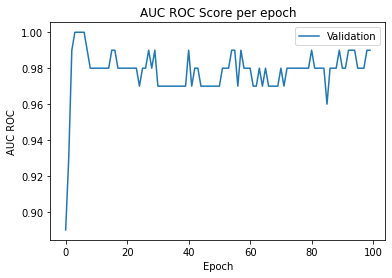

In [14]:
epochs = 100
learning_rate = 0.0001
field_road_classifier = CustomBinaryClassifier('_e100_lr1e-4') # saving_suffix : 100 epochs + lr 1e-4
optimizer = torch.optim.Adam(params=field_road_classifier.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
train_model(data_loader_train, data_loader_val, field_road_classifier, criterion, optimizer, epochs, verbose=False)

This time, the validation average loss diverges after around 20 epochs.

This means the model is overfitting on training data. I lowered again the learning rate by a factor of 10.

Training in process
End of training
Best model selected at epoch 88


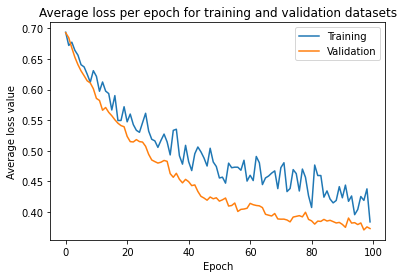

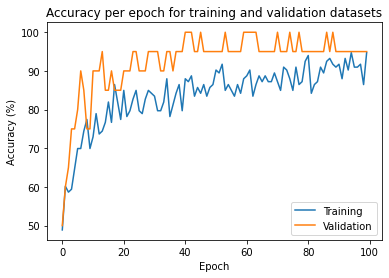

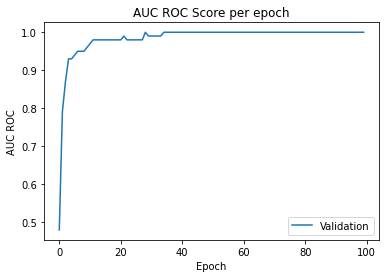

In [15]:
epochs = 100
learning_rate = 0.00001
field_road_classifier = CustomBinaryClassifier('_e100_lr1e-5') # saving_suffix : 100 epochs + lr 1e-5
optimizer = torch.optim.Adam(params=field_road_classifier.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
train_model(data_loader_train, data_loader_val, field_road_classifier, criterion, optimizer, epochs, verbose=False)

According to the validation loss per epoch, the model gradually improves its predictions on the training images as well as validation images.

However, the learning process seems not to have fully converge so I repeated it with twice more epochs.

Training in process
End of training
Best model selected at epoch 199


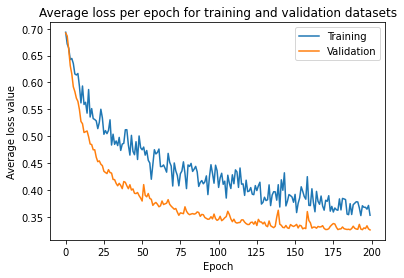

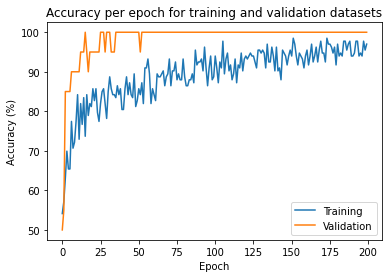

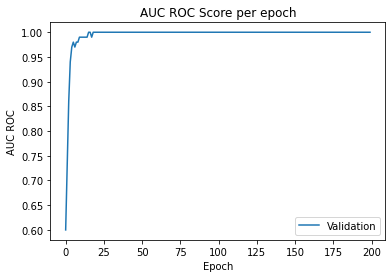

In [17]:
epochs = 200
learning_rate = 0.00001
field_road_classifier = CustomBinaryClassifier('_e200_lr1e-5') # saving_suffix : 200 epochs + lr 1e-5
optimizer = torch.optim.Adam(params=field_road_classifier.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
train_model(data_loader_train, data_loader_val, field_road_classifier, criterion, optimizer, epochs, verbose=False)

Using a lower learning rate seems to have given much better results because the validation loss curve is smooth and converges to its lowest value.

In addition, the accuracy curves shows that the model continually learns
to better predict roads and fields for both training and validation datasets.

My trained network reached 100% accuracy on the validation dataset (which implies a AUC ROC equals to 1) and the training accuracy is around 95%.

# **Predictions on test images**

Below, you will find the label predictions made on the given test images using the trained model that I consider performs the best at classifying roads and fields. As mentioned earlier, model selection is a bit tricky due to the small size of the validation set.

In [12]:
from evaluation import predict
from utils import show_image_predictions

id_to_lab = {0: 'fields', 1: 'roads'}

# Load test images / DONT SHUFFLE TEST LOADER otherwise show_predictions function will not correctly align labels with images
data_loader_test = get_data_loader(os.path.join(DATA_PATH, 'test'), 'test', BATCH_SIZE, shuffle=False) 

field_road_classifier = CustomBinaryClassifier('_e200_lr1e-5') # Select the model according to the given saving_suffix
field_road_classifier.load_best_model() # Load weights of the best saved model
predicted_labels = predict(data_loader_test, field_road_classifier, return_probabilities=False) # Predict labels for test images
labels_str = [id_to_lab[id] for id in predicted_labels.numpy()] # id to label

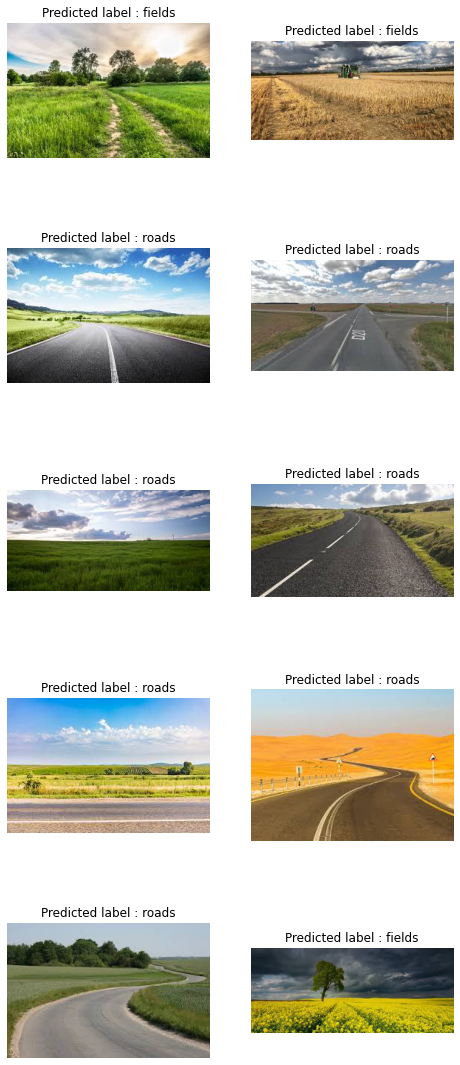

In [13]:
show_image_predictions(data_loader_test, labels_str)

One field is misclassified as a road on test images.